# Libraries

install all Libraries

pip install opencv-python numpy pandas matplotlib seaborn scikit-learn scikit-image


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import local_binary_pattern
from skimage.feature import hog



# Load dataset & Preprocessing

In [2]:
data_dir = "/Users/dani/Desktop/machine-learning-project-ml-team-3/MS" 

folders = {
    "Healthy": ["Control Axial_crop", "Control Saggital_crop"],
    "MS": ["MS Axial_crop", "MS Saggital_crop"]
}

X = []
y = []

img_size = (224, 224)

for label, subfolders in folders.items():
    for subfolder in subfolders:
        folder_path = os.path.join(data_dir, subfolder)
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                X.append(img.flatten())
                y.append(0 if label == "Healthy" else 1)
            except:
                continue

X = np.array(X)
y = np.array(y)

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (3427, 50176)
Shape y: (3427,)


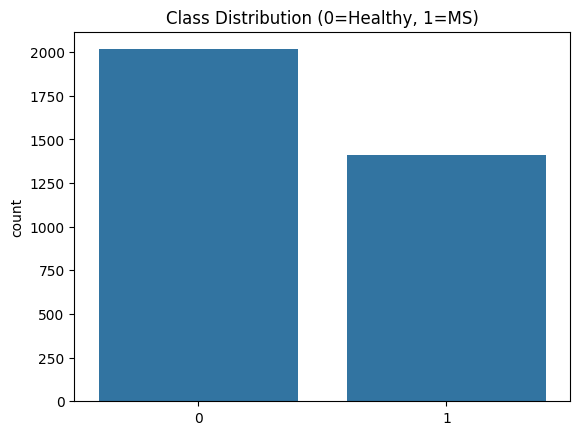

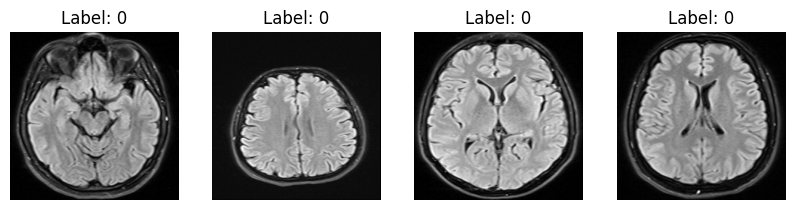

In [3]:
sns.countplot(x=y)
plt.title("Class Distribution (0=Healthy, 1=MS)")
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(224,224), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.axis("off")
plt.show()


# Feature Engineering


In [4]:
def extract_lbp_features(images, P=8, R=1):
    features = []
    for img in images:
        img_reshaped = img.reshape(224,224)
        lbp = local_binary_pattern(img_reshaped, P, R, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

X_lbp = extract_lbp_features(X)
print("LBP Features Shape:", X_lbp.shape)


LBP Features Shape: (3427, 10)


In [5]:
def extract_hog_features(images):
    features = []
    for img in images:
        img_reshaped = img.reshape(224,224)
        hog_features, _ = hog(img_reshaped, pixels_per_cell=(16, 16),
                              cells_per_block=(2, 2), visualize=True, feature_vector=True)
        features.append(hog_features)
    return np.array(features)

X_hog = extract_hog_features(X)
print("HOG Features Shape:", X_hog.shape)


HOG Features Shape: (3427, 6084)


In [6]:
X_features = np.hstack([X_lbp, X_hog])
print("Combined Features Shape:", X_features.shape)


Combined Features Shape: (3427, 6094)


scale

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_scaled)

print("PCA Features Shape:", X_pca.shape)


PCA Features Shape: (3427, 970)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm = SVC(C=3.0, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Fold {fold} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    fold += 1

print("Mean Accuracy across folds:", np.mean(accuracies))


Fold 1 Accuracy: 0.9070
Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       101
           1       0.95      0.82      0.88        71

    accuracy                           0.91       172
   macro avg       0.92      0.89      0.90       172
weighted avg       0.91      0.91      0.91       172

Fold 1 Confusion Matrix:
 [[98  3]
 [13 58]]
Fold 2 Accuracy: 0.9477
Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       101
           1       0.96      0.92      0.94        71

    accuracy                           0.95       172
   macro avg       0.95      0.94      0.95       172
weighted avg       0.95      0.95      0.95       172

Fold 2 Confusion Matrix:
 [[98  3]
 [ 6 65]]
Fold 3 Accuracy: 0.9419
Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99   

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = svm.predict(X_test)  
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy on Test Set: 0.9649122807017544

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       1.00      0.92      0.96        71

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171


Confusion Matrix:
 [[100   0]
 [  6  65]]


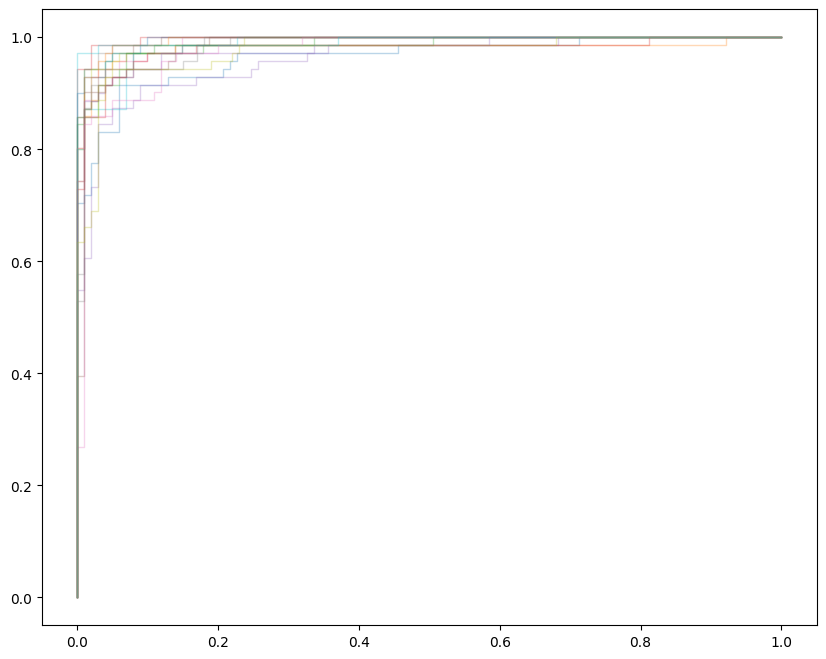

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for i, (train_idx, test_idx) in enumerate(cv.split(X_pca, y)):
    X_train_cv, X_test_cv = X_pca[train_idx], X_pca[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    
    # بناء نموذج SVM
    svm = SVC(C=3.0, kernel='rbf', gamma='scale', probability=True,
              class_weight='balanced', random_state=42)
    svm.fit(X_train_cv, y_train_cv)
    
    # توقع احتمالات الطبقة الإيجابية
    y_score = svm.predict_proba(X_test_cv)[:, 1]
    
    # حساب ROC و AUC
    fpr, tpr, _ = roc_curve(y_test_cv, y_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # تقريب TPR على نقاط FPR موحدة
    tpr_interp= np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} ROC (AUC = {roc_auc:.2f})')



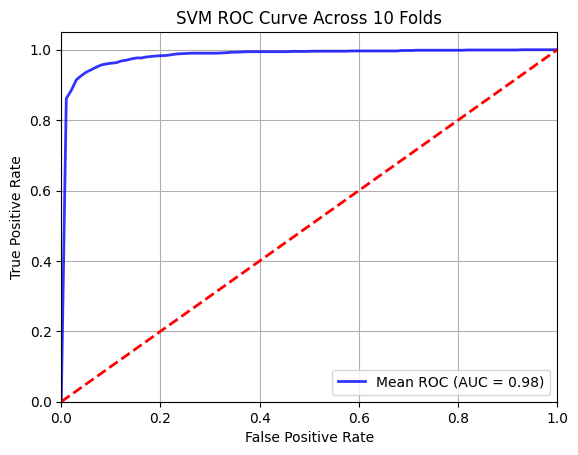

Mean AUC across folds: 0.9820102432778489
AUC per fold: [np.float64(0.9645795565472041), np.float64(0.980337470366755), np.float64(0.9905173615953144), np.float64(0.9979082415283782), np.float64(0.9598382373448613), np.float64(0.9875888997350439), np.float64(0.9863338446520709), np.float64(0.9912305516265912), np.float64(0.9909476661951909), np.float64(0.9867043847241868), np.float64(0.9951909476661952), np.float64(0.9942008486562942), np.float64(0.9858557284299859), np.float64(0.9782178217821782), np.float64(0.9792079207920792), np.float64(0.9886845827439887), np.float64(0.9802816901408451), np.float64(0.9856338028169015), np.float64(0.9722535211267606), np.float64(0.9943661971830986)]


In [13]:
# ====== 3️⃣ رسم ROC متوسط ======
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})', alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve Across 10 Folds')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ====== 4️⃣ طباعة النتائج ======
print("Mean AUC across folds:", mean_auc)
print("AUC per fold:", aucs)

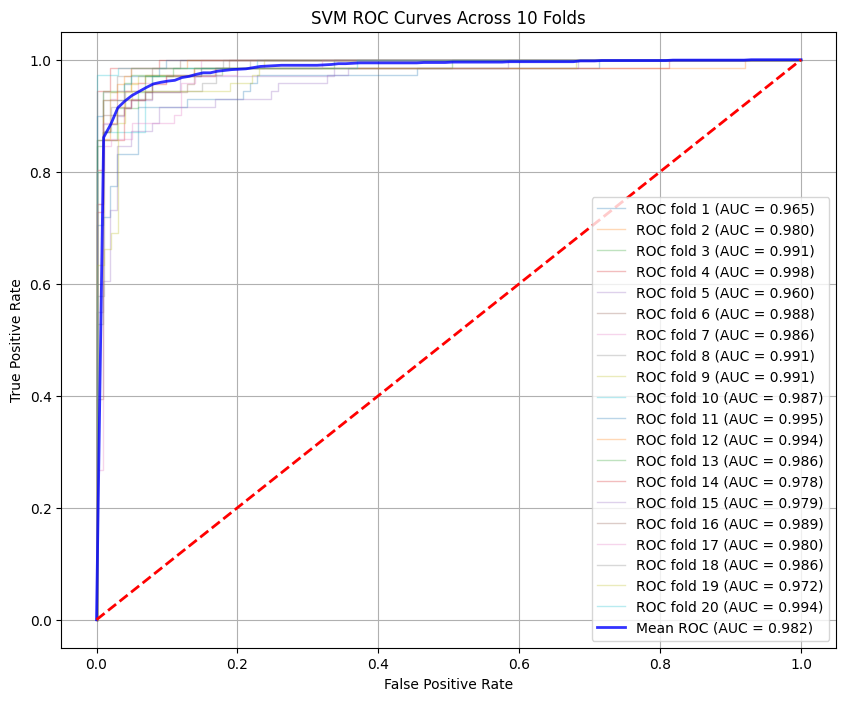

Mean AUC across folds: 0.9820102432778489
AUC per fold: [np.float64(0.9645795565472041), np.float64(0.980337470366755), np.float64(0.9905173615953144), np.float64(0.9979082415283782), np.float64(0.9598382373448613), np.float64(0.9875888997350439), np.float64(0.9863338446520709), np.float64(0.9912305516265912), np.float64(0.9909476661951909), np.float64(0.9867043847241868), np.float64(0.9951909476661952), np.float64(0.9942008486562942), np.float64(0.9858557284299859), np.float64(0.9782178217821782), np.float64(0.9792079207920792), np.float64(0.9886845827439887), np.float64(0.9802816901408451), np.float64(0.9856338028169015), np.float64(0.9722535211267606), np.float64(0.9943661971830986)]


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# تحويل الليبل إلى binary
y_bin = label_binarize(y, classes=[0,1]).ravel()

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

plt.figure(figsize=(10,8))
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fold = 1
for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm = SVC(C=3.0, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    
    y_score = svm.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate TPR to mean FPR
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {fold} (AUC = {roc_auc:.3f})')
    fold += 1

# حساب متوسط TPR و AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2, alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curves Across 10 Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("Mean AUC across folds:", mean_auc)
print("AUC per fold:", aucs)


Accuracy on Test Set: 0.9649122807017544

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       1.00      0.92      0.96        71

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171


Confusion Matrix:
 [[100   0]
 [  6  65]]


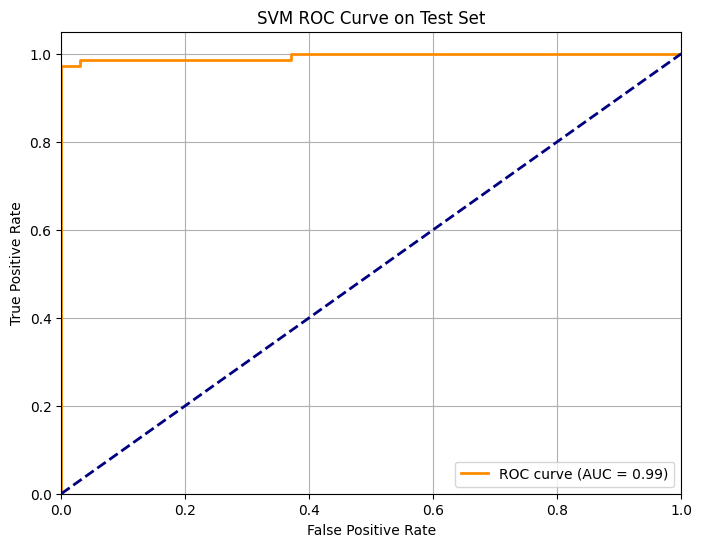

AUC on Test Set: 0.9943661971830986


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# توقع الليبل على مجموعة الاختبار
y_pred = svm.predict(X_test)

# حساب Accuracy، Classification Report و Confusion Matrix
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# تحويل الليبل إلى binary إذا لم يكن binary بالفعل
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()

# الحصول على احتمالات الطبقة الإيجابية
y_score = svm.predict_proba(X_test)[:,1]

# حساب ROC curve و AUC
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)
roc_auc = auc(fpr, tpr)

# رسم ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC on Test Set:", roc_auc)


In [16]:
# الحسابات
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9649
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       1.00      0.92      0.96        71

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171

Confusion Matrix:
 [[100   0]
 [  6  65]]


In [17]:
import joblib

# بعد ما تدرب النموذج عندك (scaler, pca, svm):
#joblib.dump(scaler, "scaler.pkl")
#joblib.dump(pca, "pca.pkl")
#joblib.dump(svm, "svm_model.pkl")

print("✅ تم حفظ النموذج وكل الأدوات بنجاح")


✅ تم حفظ النموذج وكل الأدوات بنجاح
